In [1]:
#Import Library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [26]:
import zipfile

local_zip = 'catdogSkinDisease.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [27]:
os.listdir('/tmp/data')

#number of images of each classes in the training_set folder
print(f"There are {len(os.listdir('/tmp/data/train/flea_allergy'))} train set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/train/hotspot'))} train set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/train/mange'))} train set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/train/ringworm'))} train set images of ringworm.")
print(f"There are {len(os.listdir('/tmp/data/train/leprosy'))} train set images of leprosy.")
print()

#now return the list of the content in that validation_set folder
print(f"There are {len(os.listdir('/tmp/data/validation/flea_allergy'))} val set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/validation/hotspot'))} val set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/validation/mange'))} val set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/validation/ringworm'))} val set images of ringworm.")
print(f"There are {len(os.listdir('/tmp/data/validation/leprosy'))} val set images of leprosy.")
print()

#now return the list of the content in that testing_set folder
print(f"There are {len(os.listdir('/tmp/data/test/flea_allergy'))} test set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/test/hotspot'))} test set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/test/mange'))} test set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/test/ringworm'))} test set images of ringworm.")
print(f"There are {len(os.listdir('/tmp/data/test/leprosy'))} test set images of leprosy.")

There are 76 train set images of flea allergy.
There are 96 train set images of hotspot.
There are 63 train set images of mange.
There are 138 train set images of ringworm.
There are 249 train set images of leprosy.

There are 20 val set images of flea allergy.
There are 20 val set images of hotspot.
There are 20 val set images of mange.
There are 20 val set images of ringworm.
There are 22 val set images of leprosy.

There are 20 test set images of flea allergy.
There are 20 test set images of hotspot.
There are 20 test set images of mange.
There are 20 test set images of ringworm.
There are 60 test set images of leprosy.


In [28]:
TRAINING_DIR = "/tmp/data/train"
VALIDATION_DIR = "/tmp/data/validation"
TESTING_DIR = "/tmp/data/test"

TRAINING_FLEA_DIR = "/tmp/data/train/flea_allergy"
VALIDATION_FLEA_DIR = "/tmp/data/validation/flea_allergy"
TEST_FLEA_DIR = "/tmp/data/test/flea_allergy"

TRAINING_HOTSPOT_DIR = "/tmp/data/train/hotspot"
VALIDATION_HOTSPOT_DIR = "/tmp/data/validation/hotspot"
TESTING_HOTSPOT_DIR = "/tmp/data/test/hotspot"

TRAINING_MANGE_DIR = "/tmp/data/train/mange"
VALIDATION_MANGE_DIR = "/tmp/data/validation/mange"
TESTING_MANGE_DIR = "/tmp/data/test/mange"

TRAINING_RINGWORM_DIR = "/tmp/data/train/ringworm"
VALIDATION_RINGWORM_DIR = "/tmp/data/validation/ringworm"
TESTING_RINGWORM_DIR = "/tmp/data/test/ringworm"

TRAINING_LEPROSY_DIR = "/tmp/data/train/leprosy"
VALIDATION_LEPROSY_DIR = "/tmp/data/validation/leprosy"
TESTING_LEPROSY_DIR = "/tmp/data/test/leprosy"

In [29]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                     fill_mode='nearest',
                                     rotation_range=45,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(100, 100))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                          batch_size=128,
                                                          class_mode='categorical',
                                                          target_size=(100, 100))
  ### END CODE HERE
  return train_generator, validation_generator

In [30]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 622 images belonging to 5 classes.
Found 102 images belonging to 5 classes.


In [31]:
def show_image_samples(gen):
  train_dict = train_generator.class_indices
  classes = list(train_dict.keys())
  images, labels = next(gen) #get a sample batch from generator
  plt.figure(figsize=(20,20))
  length = len(labels)
  if length < 10:
    r = length
  else:
    r = 10
  for i in range(r):
    plt.subplot(5, 5, i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='black', fontsize=18)
    plt.axis('off')
  plt.show()

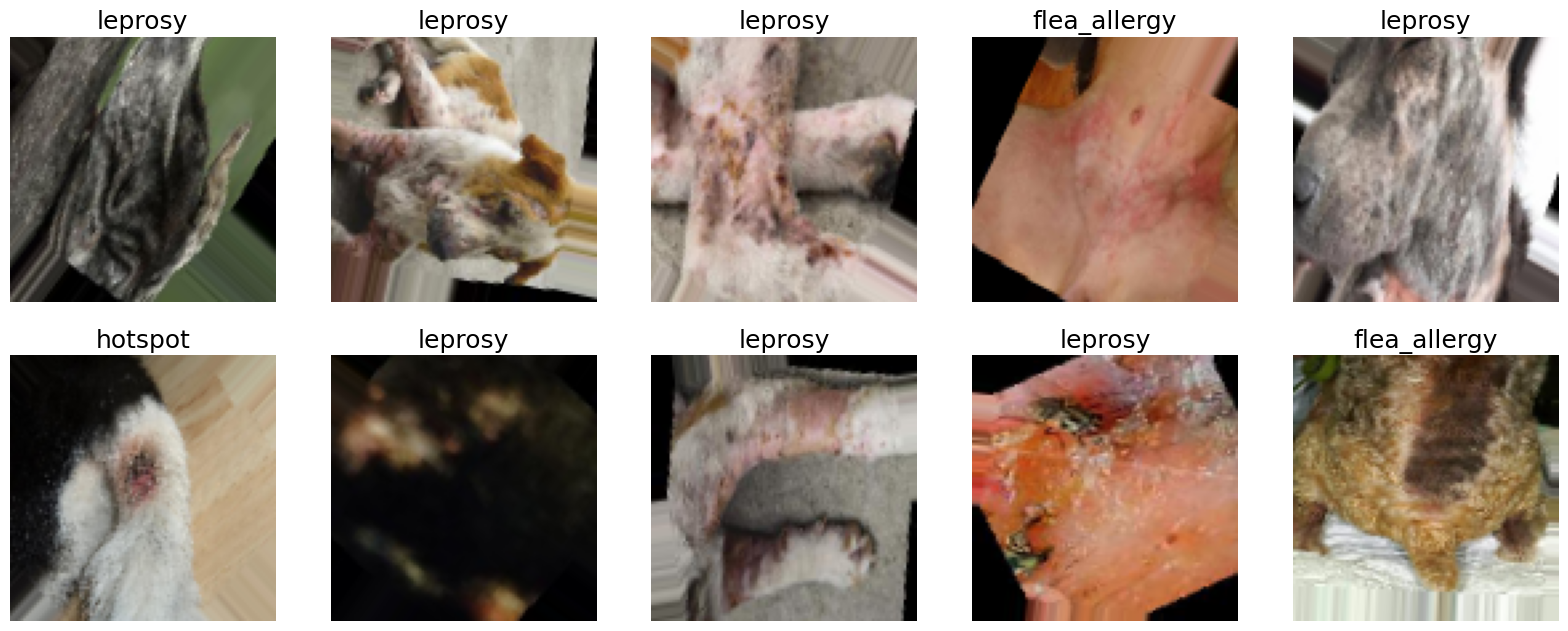

In [32]:
show_image_samples(train_generator)

In [33]:
IMAGE_SIZE = [100, 100]
 
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
 
for layer in inception.layers:
    layer.trainable = False
model = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1028, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [34]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 

In [35]:
EPOCHS = 25

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=50,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=20)

Epoch 1/25


C:\Users\Latifatul Khumairoh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - accuracy: 0.2494 - loss: 13.8801 - val_accuracy: 0.2059 - val_loss: 5.1480
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.3166 - loss: 2.6061 - val_accuracy: 0.2745 - val_loss: 1.9969
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.4959 - loss: 1.3375 - val_accuracy: 0.3824 - val_loss: 1.4402
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.4423 - loss: 1.4381 - val_accuracy: 0.4020 - val_loss: 1.4399
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5473 - loss: 1.2485 - val_accuracy: 0.2843 - val_loss: 2.1153
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.4584 - loss: 1.4000 - val_accuracy: 0.3333 - val_loss: 1.4965
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.5849 - loss: 1.0629 - val_accuracy: 0.2745 - val_loss: 1.7920
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5634 - loss: 1.2213 - val_accuracy: 0.45

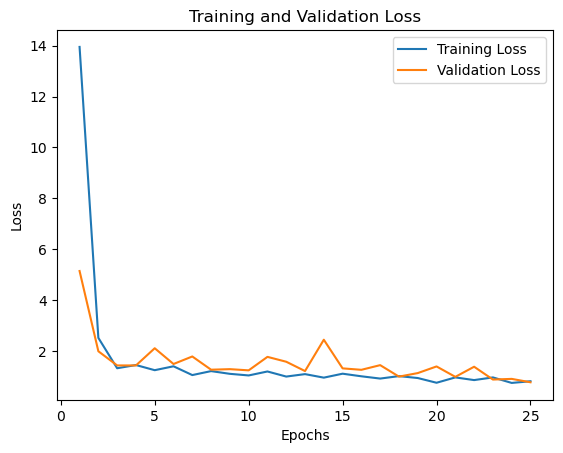

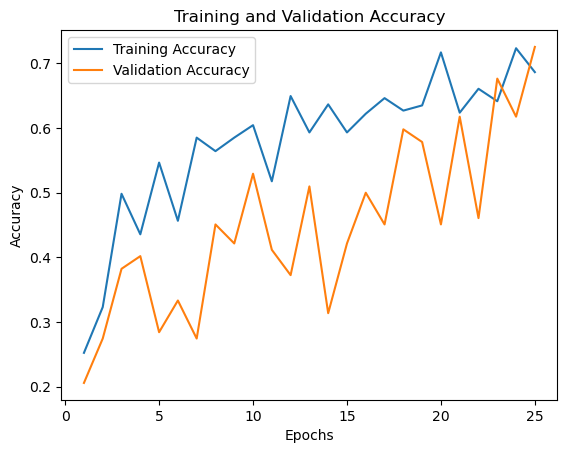

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


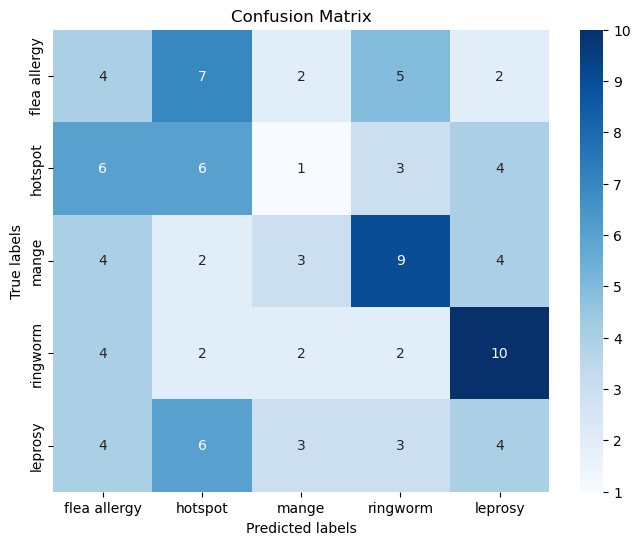

              precision    recall  f1-score   support

flea allergy       0.18      0.20      0.19        20
     hotspot       0.26      0.30      0.28        20
       mange       0.27      0.14      0.18        22
    ringworm       0.09      0.10      0.10        20
     leprosy       0.17      0.20      0.18        20

    accuracy                           0.19       102
   macro avg       0.19      0.19      0.19       102
weighted avg       0.20      0.19      0.19       102



In [38]:
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

#Confusion Matrix Inception V3
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy'], 
            yticklabels=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy']))


C:\Users\Latifatul Khumairoh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_196 (Conv2D)                  │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_196              │ (None, 98, 98, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_197 (Conv2D)                  │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_197              │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_198 (Conv2D)                  │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_198              │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_199 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_199              │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,205 (465.64 KB)

 Trainable params: 118,725 (463.77 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/25
 5/25 ━━━━━━━━━━━━━━━━━━━━ 11s 565ms/step - accuracy: 0.1908 - loss: 1.6986

C:\Users\Latifatul Khumairoh\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.2388 - loss: 1.6345 - val_accuracy: 0.2157 - val_loss: 1.6074
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.4125 - loss: 1.4234 - val_accuracy: 0.2157 - val_loss: 1.6087
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.4662 - loss: 1.2988 - val_accuracy: 0.2157 - val_loss: 1.6173
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.4960 - loss: 1.2801 - val_accuracy: 0.2157 - val_loss: 1.6257
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5025 - loss: 1.2521 - val_accuracy: 0.2157 - val_loss: 1.6413
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.5110 - loss: 1.2343 - val_accuracy: 0.2157 - val_loss: 1.6490
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.5466 - loss: 1.1599 - val_accuracy: 0.2157 - val_loss: 1.6495
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.5265 - loss: 1.1934 - val_accuracy: 0.215

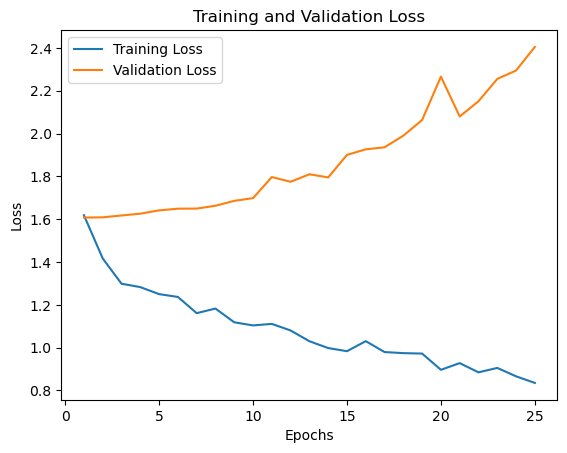

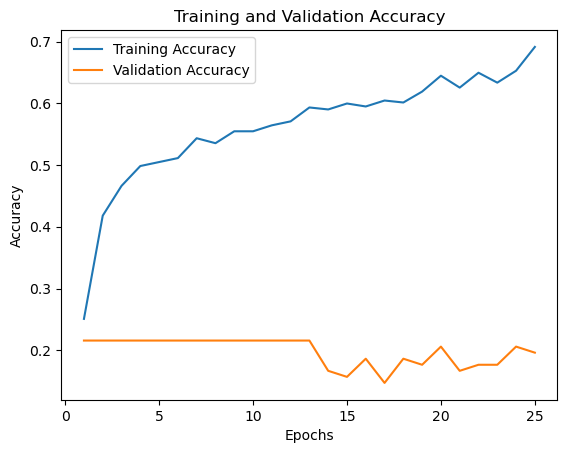

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


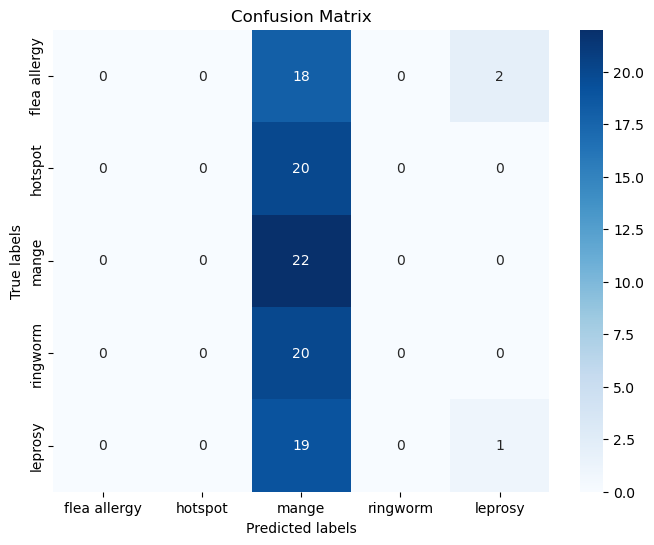

              precision    recall  f1-score   support

flea allergy       0.00      0.00      0.00        20
     hotspot       0.00      0.00      0.00        20
       mange       0.22      1.00      0.36        22
    ringworm       0.00      0.00      0.00        20
     leprosy       0.33      0.05      0.09        20

    accuracy                           0.23       102
   macro avg       0.11      0.21      0.09       102
weighted avg       0.11      0.23      0.10       102



C:\Users\Latifatul Khumairoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Latifatul Khumairoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Latifatul Khumairoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
def create_model():
    model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(100, 100, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),  # Mengubah tensor 4D menjadi tensor 2D
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 

    return model2

# Verifikasi ukuran input
model2 = create_model()
model2.summary()

model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

EPOCHS = 25

# Train the model
history2 = model2.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=25)

loss = history2.history['loss']
val_loss = history2.history['val_loss']
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

predictions = model2.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

#Confusion Matrix Inception V3
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy'], 
            yticklabels=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy']))

Epoch 1/25
 5/25 ━━━━━━━━━━━━━━━━━━━━ 2:11 7s/step - accuracy: 0.2040 - loss: 1.7293

C:\Users\Latifatul Khumairoh\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2697 - loss: 1.6430 - val_accuracy: 0.2157 - val_loss: 1.8610
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4207 - loss: 1.4159 - val_accuracy: 0.2255 - val_loss: 1.7176
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4569 - loss: 1.3045 - val_accuracy: 0.2941 - val_loss: 1.6083
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4917 - loss: 1.2154 - val_accuracy: 0.3235 - val_loss: 1.5349
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5313 - loss: 1.1415 - val_accuracy: 0.3922 - val_loss: 1.4259
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.5914 - loss: 1.0749 - val_accuracy: 0.4216 - val_loss: 1.3875
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5785 - loss: 1.0417 - val_accuracy: 0.4608 - val_loss: 1.3128
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6102 - loss: 0.9998 - val_accuracy: 0.4804 - val_loss: 1.1948
Ep

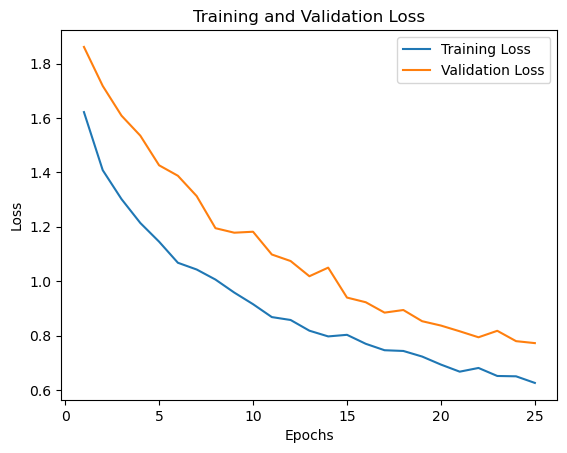

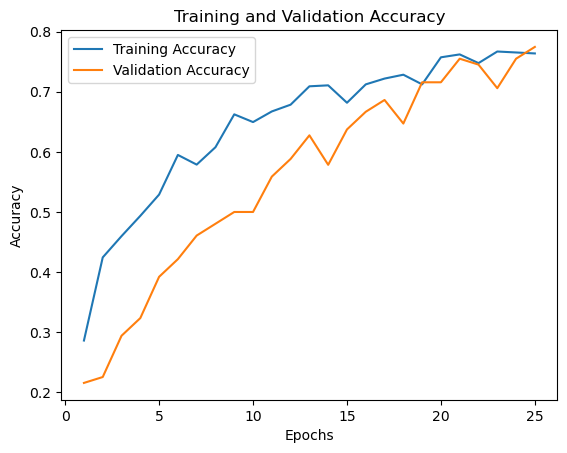

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


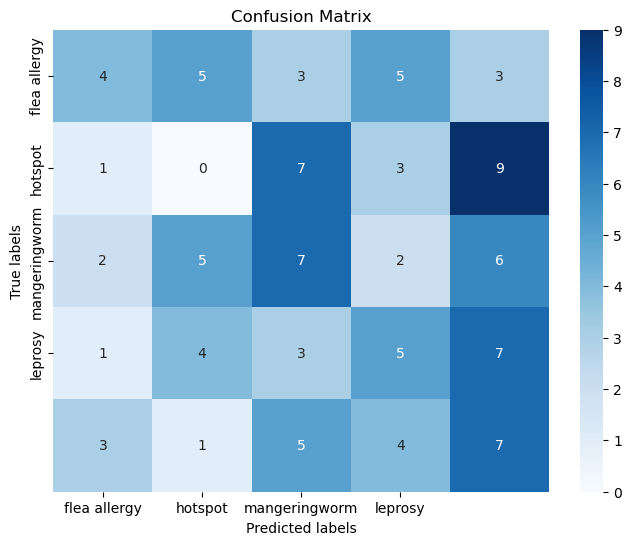

              precision    recall  f1-score   support

flea allergy       0.36      0.20      0.26        20
     hotspot       0.00      0.00      0.00        20
       mange       0.28      0.32      0.30        22
    ringworm       0.26      0.25      0.26        20
     leprosy       0.22      0.35      0.27        20

    accuracy                           0.23       102
   macro avg       0.23      0.22      0.22       102
weighted avg       0.23      0.23      0.22       102



In [41]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False ## Not trainable weights

## Preprocessing input
#train_ds = preprocess_input(train_generator) 
#test_ds = preprocess_input(validation_generator)

from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

EPOCHS = 25

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=25)

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

#Confusion Matrix Inception V3
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['flea allergy', 'hotspot', 'mange' 'ringworm', 'leprosy'], 
            yticklabels=['flea allergy', 'hotspot', 'mange' 'ringworm', 'leprosy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Classification report
print(classification_report(true_labels, predicted_labels, target_names=['flea allergy', 'hotspot', 'mange', 'ringworm', 'leprosy']))

In [24]:
# #pip install transformers
# #!pip install torch torchvision


# from transformers import AutoImageProcessor, ResNetForImageClassification
# #import torch
# from datasets import load_dataset
# from PIL import Image

# processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
# model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# inputs = processor(train_generator, return_tensors="pt")

# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_label = logits.argmax(-1).item()
# print(model.config.id2label[predicted_label])